In [1]:
import os
import sys
sys.path.append('../source/maskrcnn')
sys.path.append('../source/dataset')
sys.path.append('../source/miq')
sys.path.append('../source')
sys.path.append('C:\\Program Files\\Micro-Manager-2.0beta')

import utils
import model as modellib
import visualize
import config

from const import *
import mark_dataset
import alignment
import time

import chip
import position as pos
import focus
import sc_utils

# Load a Micro-Manager instance
mmc = sc_utils.get_mmc()
print ("Stage at: (", mmc.getXPosition(), 
       ",", mmc.getYPosition(), ")")
mmc.setProperty("LED:L:37:1","State", "Closed")
mmc.setProperty("LED:L:37:2","State", "Closed")
mmc.setProperty("LED:L:37:3","State", "Open")
mmc.setProperty("LED:L:37:4","State", "Closed")	
mmc.setProperty("LED:L:37:1","LED Intensity(%)", "100")
mmc.setProperty("LED:L:37:2","LED Intensity(%)", "100")
mmc.setProperty("LED:L:37:3","LED Intensity(%)", "100")
mmc.setProperty("LED:L:37:4","LED Intensity(%)", "100")
mmc.setState("FilterSlider:S:33", 0)

Using TensorFlow backend.


Stage at: ( 99880.12 , 39181.06 )


In [2]:
''' Name chip and give directory to save in '''
chip_number = '0009' 
save_dir = 'C:\\Users\\Jay\\Miniconda3\\envs\\smartscope\\Data\\' + chip_number
os.makedirs(save_dir, exist_ok=True)

## Auto-Alignment

In [3]:
model = alignment.get_inference_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  C:\Users\Jay\Miniconda3\envs\SmartScope\python\notebook\adjusted_frame_alignment_20_original.h5


In [4]:
start = time.time()

center, img, frame, r = alignment.find_alignment_mark(model)
alignment.move_to_center(mmc, center)
p1 = pos.StagePosition(x=mmc.getXPosition(),
                       y=mmc.getYPosition())
pos.set_pos(mmc, x=(p1.x -CHIP_WIDTH),
                 y=p1.y)
pos.set_pos(mmc, z=focus.focus_point(mmc))

center, img, frame, r = alignment.find_alignment_mark(model)
alignment.move_to_center(mmc, center)
p2 = pos.StagePosition(x=mmc.getXPosition(),
                       y=mmc.getYPosition())
pos.set_pos(mmc, x=(p2.x),
                 y=(p2.y - CHIP_HEIGHT))
pos.set_pos(mmc, z=focus.focus_point(mmc))

center, img, frame, r = alignment.find_alignment_mark(model)
alignment.move_to_center(mmc, center)
p3 = pos.StagePosition(x=mmc.getXPosition(),
                       y=mmc.getYPosition())

align_time = time.time()
print ('Time for alignment:', align_time-start)

# Create a Position List of the corners and save it
corners = pos.PositionList(positions=[p1,p2,p3])
corners.save(chip_number + '_corners', save_dir)
# Create a chip instance and visualize the focus Position List 
current_chip = chip.Chip(corners)
focus_pl = current_chip.get_focus_position_list(5,4)

focused_pl = focus.focus_from_last_point(focus_pl, mmc, delta_z=10)
focused_pl.save(chip_number + '_focused', save_dir)

focus_time = time.time()
print ('Time for focus:', focus_time-align_time)

imaging_pl = current_chip.get_position_list(focused_pl, cam_frame_width=FRAME_WIDTH,
                                                        cam_frame_height=FRAME_HEIGHT)
imaging_pl.image(mmc, save_dir, save_jpg=False)

end = time.time()
print ('Time for imaging:', end-focus_time)
print ('Total time:', end-start)


(1024, 1376)
Processing 1 images
image                    shape: (1024, 1376, 3)       min:    1.00000  max:   52.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  -52.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1376.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model.ckpt-1000042
(1024, 1376)
Processing 1 images
image                    shape: (1024, 1376, 3)       min:    1.00000  max:   57.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  -47.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1376.00000  float6

## Load previously saved Positions

In [7]:
current_chip = chip.Chip(pos.load('\\'+chip_number + '_corners', save_dir))
focused_pl = pos.load('\\'+chip_number + '_focused', save_dir)
imaging_pl = current_chip.get_position_list(focused_pl)
imaging_pl.image(mmc, save_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Jay\\Miniconda3\\envs\\smartscope\\Data\\0009\\0009_corners.json'

In [4]:
pos.set_pos(mmc, x=99880, y=39181.74)
ox, oy, oz = pos.current(mmc)
print(ox, oy, oz)

99880.1 39181.74 -2977.79


## Run this cell to view bounding box on image

(1024, 1376)
Processing 1 images
image                    shape: (1024, 1376, 3)       min:    1.00000  max:   50.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  -54.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1376.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


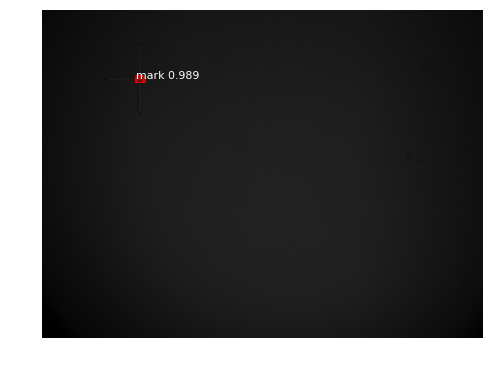

In [4]:
center, img, frame, r = alignment.find_alignment_mark(model)
visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'], 
                            alignment.classnames, r['scores'],figsize=(8, 8))

## Now move to that point and show it again

(1024, 1376)
Processing 1 images
image                    shape: (1024, 1376, 3)       min:    1.00000  max:   60.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  -44.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1376.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


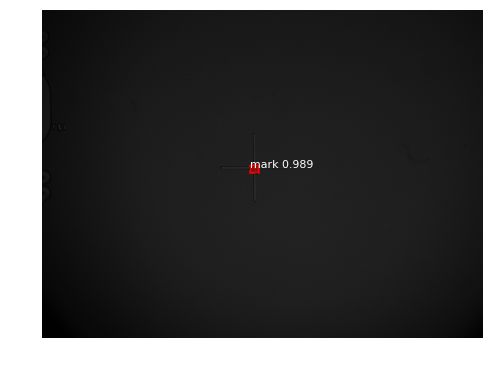

In [5]:
alignment.move_to_center(mmc, center)

center, img, frame, r = alignment.find_alignment_mark(model)

visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'], 
                            alignment.classnames, r['scores'],figsize=(8, 8))

(1024, 1376)


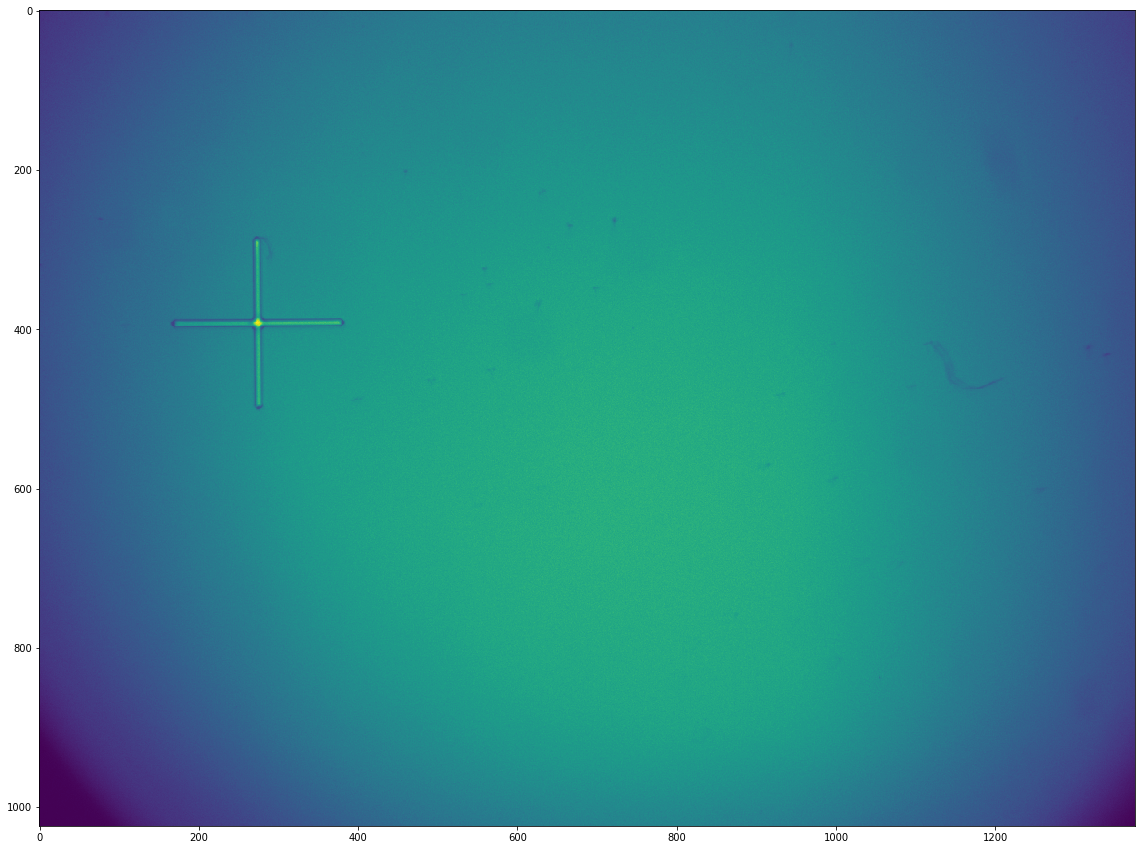

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]
frame = alignment.get_frame()
plt.imshow(frame)

In [6]:
center

array([664., 493.])

In [5]:
pos.set_pos(mmc, x=99880, y=39181, z=-2977.79)
# mmc.setProperty("LED:L:37:3","LED Intensity(%)", "20")
# nx, ny, nz = pos.current(mmc)
# print(ox, oy, oz)

In [9]:
pos.set_pos(mmc, x=99500, y=39065)
nx, ny, nz = pos.current(mmc)

In [7]:
pos.set_pos(mmc, x=99500+26000, y=39065)

In [7]:
frame = alignment.get_frame()
plt.imshow(frame)

(1024, 1376)


NameError: name 'plt' is not defined